In [1]:
# !pip install mediapipe

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [3]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [4]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [5]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [10]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [11]:
# !pip install moviepy

In [12]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 62

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [16]:
DATA_PATH

'data2'

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
np.array(sequences).shape

(372, 30, 1662)

In [19]:
np.array(labels).shape

(372,)

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(372, 30, 1662)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [25]:
y_test.shape

(19, 6)

## Build Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
import tensorflow as tf

In [29]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        return output, attention_scores

In [30]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [31]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [32]:
def custom_reward(y_true, y_pred):
    correct_predictions = tf.reduce_sum(y_true * y_pred)
    
    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]))
    
    external_metric_bonus = 0.3

    reward = correct_predictions - 0.1 * diversity_penalty - 0.2 * weighted_mistakes_penalty + external_metric_bonus

    return reward

In [33]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    reward = custom_reward(y_true, y_pred)
    # print(type(y_true))
    # reward=0.5
    return loss - 0.1 * reward

In [34]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [35]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [36]:
X_train.shape,y_train.shape

((353, 30, 1662), (353, 6))

In [37]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
12/12 [==============================] - 12s 200ms/step - loss: 8.2276 - categorical_accuracy: 0.1728
Epoch 2/50
12/12 [==============================] - 2s 207ms/step - loss: 8.6696 - categorical_accuracy: 0.1615
Epoch 3/50
12/12 [==============================] - 3s 217ms/step - loss: 4.2532 - categorical_accuracy: 0.2550
Epoch 4/50
12/12 [==============================] - 3s 285ms/step - loss: 2.2930 - categorical_accuracy: 0.2663
Epoch 5/50
12/12 [==============================] - 3s 230ms/step - loss: 2.1248 - categorical_accuracy: 0.1955
Epoch 6/50
12/12 [==============================] - 3s 287ms/step - loss: 1.4696 - categorical_accuracy: 0.3088
Epoch 7/50
12/12 [==============================] - 4s 289ms/step - loss: 1.3997 - categorical_accuracy: 0.3881
Epoch 8/50
12/12 [==============================] - 3s 290ms/step - loss: 1.8855 - categorical_accuracy: 0.2351
Epoch 9/50
12/12 [==============================] - 4s 351ms/step - loss: 1.4350 - categorical_accuracy

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           916992    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


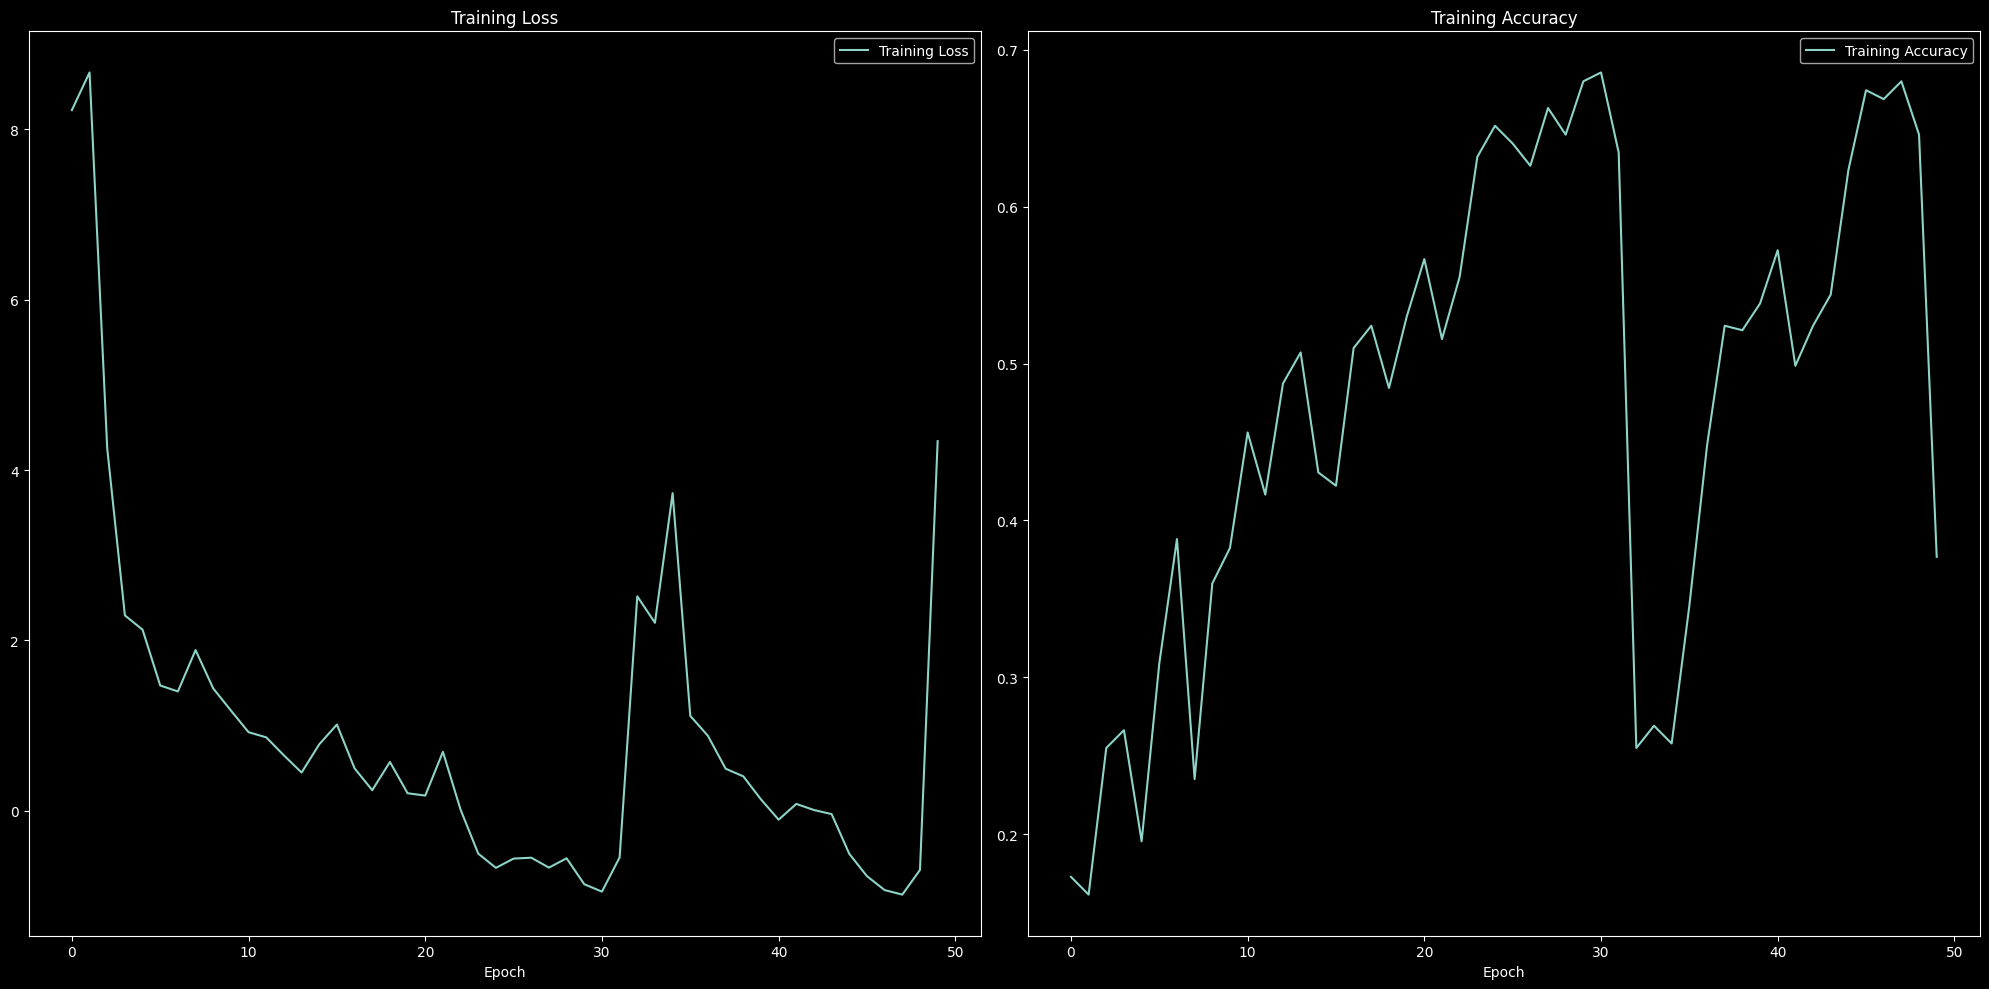

In [39]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 703ms/step


In [41]:
y_p.shape

(19, 6)

In [42]:
y_test.shape

(19, 6)

In [43]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [44]:
# calculate_reward(y_test,y_p)

In [45]:
res = model.predict(X_test)

1/1 [==============================] - 0s 86ms/step


In [46]:
X_test

array([[[ 0.58312249,  0.64417672, -2.32569361, ...,  0.45794398,
          0.63795102, -0.01331117],
        [ 0.58337539,  0.64374435, -2.42984509, ...,  0.4519099 ,
          0.62131327,  0.00328704],
        [ 0.58339942,  0.644517  , -2.50160193, ...,  0.45019746,
          0.62273943, -0.00975352],
        ...,
        [ 0.58587706,  0.6435703 , -2.48225451, ...,  0.44799602,
          0.593099  , -0.04091475],
        [ 0.58555484,  0.64228725, -2.49713326, ...,  0.50010163,
          0.56618953, -0.04607233],
        [ 0.58364069,  0.64064801, -2.50138283, ...,  0.46458119,
          0.60314143, -0.04417122]],

       [[ 0.46949047,  0.64530289, -1.37623572, ...,  0.33323365,
          0.51410055,  0.00972886],
        [ 0.46967554,  0.64410144, -1.29458725, ...,  0.33648196,
          0.50360709,  0.01292268],
        [ 0.46999732,  0.64131981, -1.25960982, ...,  0.33648413,
          0.48755017,  0.01707772],
        ...,
        [ 0.42753157,  0.74071419, -1.4892571 , ...,  

In [47]:
res

array([[5.86817749e-02, 7.45065263e-05, 2.36784376e-06, 2.88222700e-01,
        6.53009772e-01, 8.85464306e-06],
       [1.13422252e-01, 4.47884109e-03, 4.85024182e-04, 2.01319739e-01,
        6.79196954e-01, 1.09718484e-03],
       [2.11101428e-01, 8.86792783e-04, 2.74779246e-04, 4.24719393e-01,
        3.62645179e-01, 3.72450915e-04],
       [2.31977552e-01, 1.51138142e-04, 7.24940546e-05, 5.18687904e-01,
        2.49064341e-01, 4.65710291e-05],
       [2.03907758e-01, 7.44748977e-04, 3.03985260e-04, 4.68999684e-01,
        3.25807750e-01, 2.36023916e-04],
       [2.22691685e-01, 2.55436607e-04, 1.29951281e-04, 5.36805212e-01,
        2.40036145e-01, 8.15766689e-05],
       [1.43372849e-01, 9.90574830e-04, 1.49972853e-04, 3.46800357e-01,
        5.08303046e-01, 3.83208389e-04],
       [1.95920587e-01, 1.27920543e-03, 3.52437666e-04, 4.27217335e-01,
        3.74722600e-01, 5.07806719e-04],
       [5.71159832e-02, 2.95927911e-03, 6.37171106e-05, 1.15365796e-01,
        8.23340476e-01, 

In [48]:
actions[np.argmax(res[4])]

'neutral'

In [49]:
actions[np.argmax(y_test[4])]

'anger'

In [50]:
model.save('action_with_Reward2.h5')

H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [52]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 81ms/step


In [53]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [54]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[16,  0],
        [ 3,  0]],

       [[18,  0],
        [ 1,  0]],

       [[10,  0],
        [ 9,  0]],

       [[11,  6],
        [ 1,  1]],

       [[ 7, 11],
        [ 0,  1]],

       [[16,  0],
        [ 3,  0]]], dtype=int64)

In [55]:
accuracy_score(ytrue, yhat)

0.10526315789473684

In [56]:
for num, prob in enumerate(res):
    print(num,prob)

0 [5.8681775e-02 7.4506526e-05 2.3678438e-06 2.8822270e-01 6.5300977e-01
 8.8546431e-06]
1 [1.1342225e-01 4.4788411e-03 4.8502418e-04 2.0131974e-01 6.7919695e-01
 1.0971848e-03]
2 [2.1110143e-01 8.8679278e-04 2.7477925e-04 4.2471939e-01 3.6264518e-01
 3.7245092e-04]
3 [2.3197755e-01 1.5113814e-04 7.2494055e-05 5.1868790e-01 2.4906434e-01
 4.6571029e-05]
4 [2.0390776e-01 7.4474898e-04 3.0398526e-04 4.6899968e-01 3.2580775e-01
 2.3602392e-04]
5 [2.2269168e-01 2.5543661e-04 1.2995128e-04 5.3680521e-01 2.4003614e-01
 8.1576669e-05]
6 [1.4337285e-01 9.9057483e-04 1.4997285e-04 3.4680036e-01 5.0830305e-01
 3.8320839e-04]
7 [1.9592059e-01 1.2792054e-03 3.5243767e-04 4.2721733e-01 3.7472260e-01
 5.0780672e-04]
8 [5.71159832e-02 2.95927911e-03 6.37171106e-05 1.15365796e-01
 8.23340476e-01 1.15474151e-03]
9 [1.4027241e-01 1.2579778e-03 1.8117134e-04 3.3702239e-01 5.2077180e-01
 4.9428467e-04]
10 [1.5544924e-01 8.2783005e-04 1.3380256e-04 3.6636093e-01 4.7692040e-01
 3.0787787e-04]
11 [1.3589232e

In [57]:
from scipy import stats

In [58]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


In [59]:
# prob_viz(res[0], actions, image, colors)

In [60]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [61]:
import tensorflow as tf

In [62]:
model = tf.keras.models.load_model("action_with_Reward2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [63]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

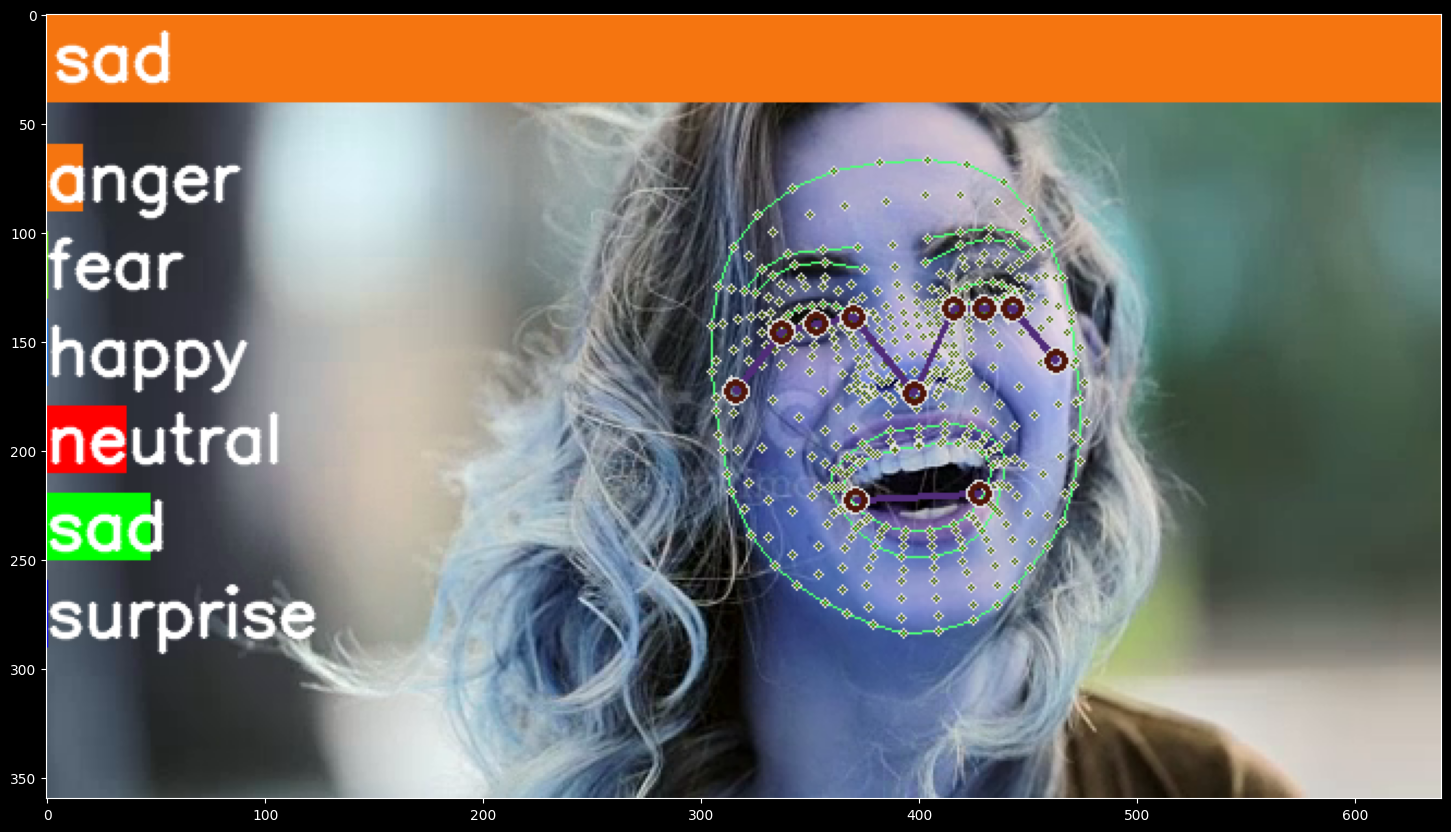

In [64]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [65]:
# history

In [66]:
res

array([1.6162337e-01, 1.3318264e-03, 2.3561978e-04, 3.6519116e-01,
       4.7110209e-01, 5.1583047e-04], dtype=float32)

In [67]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.16162337
fear ----> 0.0013318264
happy ----> 0.00023561978
neutral ----> 0.36519116
sad ----> 0.4711021
surprise ----> 0.00051583047


In [68]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

Indices of the top 3 elements: [4 3]


In [69]:
ans=[]

In [70]:
for i in top_indices:
    ans.append(actions[i])

In [71]:
ans

['sad', 'neutral']

In [72]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [73]:
res

array([2.5850809e-03, 3.8890725e-01, 4.4436482e-04, 6.8307929e-03,
       6.0099316e-01, 2.3939666e-04], dtype=float32)

In [74]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.002585081
fear ----> 0.38890725
happy ----> 0.00044436482
neutral ----> 0.006830793
sad ----> 0.60099316
surprise ----> 0.00023939666


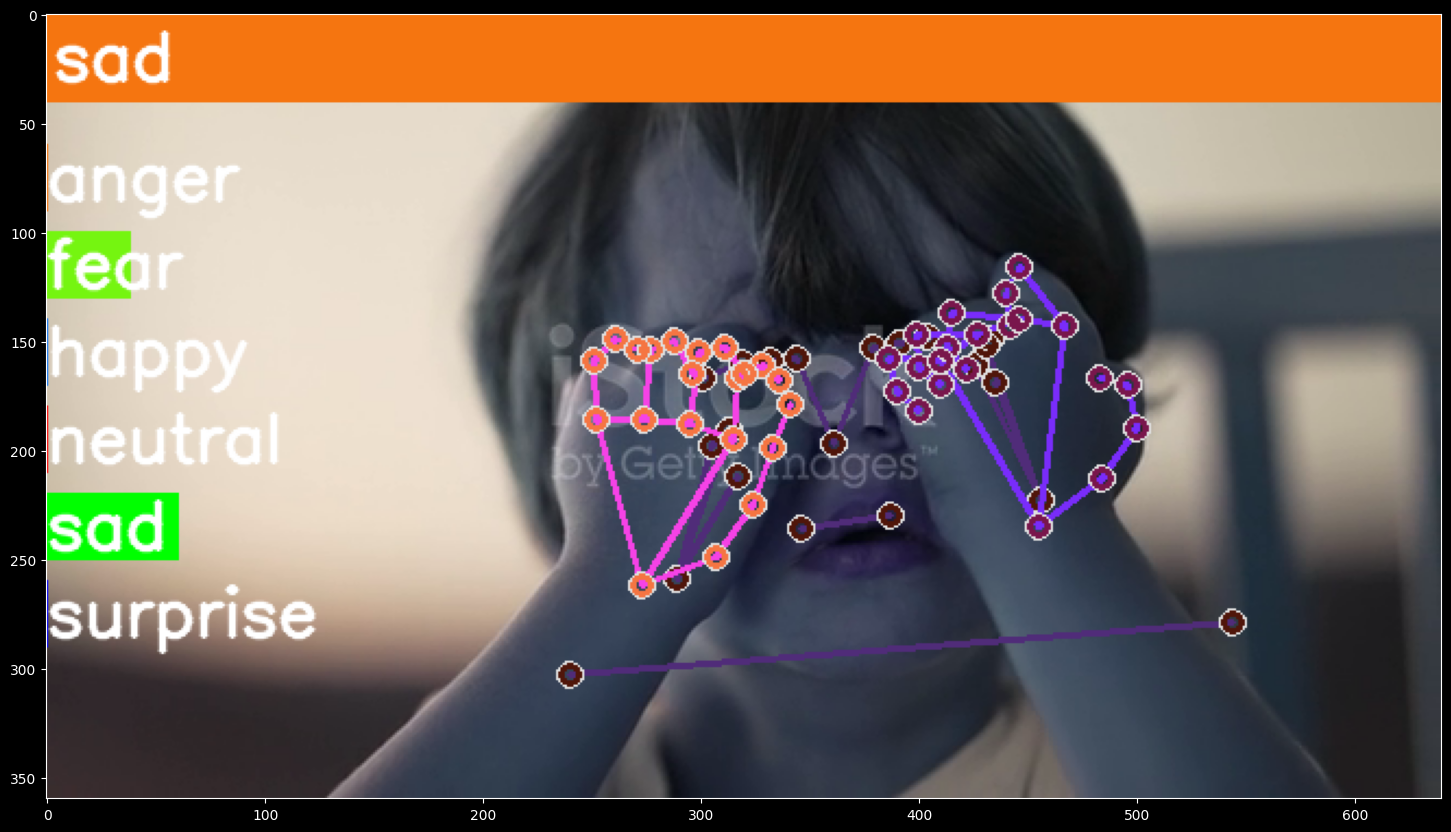

In [75]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [76]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [77]:
res

array([1.0903092e-01, 9.3817100e-04, 8.4578314e-05, 3.3014598e-01,
       5.5952889e-01, 2.7137945e-04], dtype=float32)

In [78]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 0.10903091728687286
fear ----> 0.0009381709969602525
happy ----> 8.457831427222118e-05
neutral ----> 0.3301459848880768
sad ----> 0.5595288872718811
surprise ----> 0.00027137945289723575


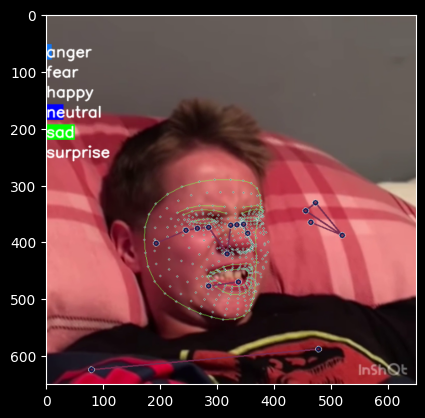

In [79]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 650))
plt.imshow(resized_image)
plt.show()